In [6]:
import sys
import pandas as pd
import urllib
from bs4 import BeautifulSoup as bs
import requests
import io
PROJECT_ROOT=r"C:\Users\Pedro\Desktop\Python Notes\Programs\Untitled Folder"
sys.path.insert(0, PROJECT_ROOT)

In [7]:
URL  =  "http://rotoguru1.com/cgi-bin/fyday.pl?week=WK&year=2017&game=dk&scsv=1"
weeks = list(range(1,18, 1))

In [8]:
df = pd.DataFrame()
for w in weeks:
    URL = URL.replace("WK", str(w))
    request = requests.get(URL)
    data = request.text
    temp_df=pd.read_csv(io.StringIO(bs(data, "html.parser").find("pre").text), sep=";")
    df = pd.concat([df, temp_df])
    URL = "http://rotoguru1.com/cgi-bin/fyday.pl?week=WK&year=2017&game=dk&scsv=1"
del temp_df
del weeks
del w
del df["GID"]

In [9]:
df.set_index(["Pos", "Name", "Year", "Week", "Oppt"], inplace=True)

In [10]:
defense = pd.DataFrame()
position = ["QB", "RB", "WR", "TE"]
for p in position:
    opt_rb = df.xs(p, level = 'Pos')
    opt_rb = opt_rb.groupby(["Week", "Oppt"]).sum()
    opt_rb = opt_rb.drop(columns=["DK salary"])
    opt_rb ["Pos"] = p
    defense = pd.concat([defense, opt_rb])
del p
del opt_rb
del position

In [11]:
opt_mean = round(defense.groupby(["Oppt", "Pos"]).mean(),2)
opt_mean = opt_mean.rename(columns={"DK points": "Oppt Average Points Allowed"})

In [12]:
df.reset_index(inplace=True)
opt_mean.reset_index(inplace=True)
df = pd.merge(df, opt_mean, on=["Pos", "Oppt"])
df.set_index(["Pos", "Name", "Year", "Week", "Oppt"], inplace=True)
del opt_mean

In [13]:
df_mean = df.drop(columns=["DK salary"])
df_mean = round(df_mean.groupby(["Name", "Pos", "Year"]).mean(), 2)
df_mean = df_mean.rename(columns={"DK points":"Avg points"})

In [14]:
df_std = df.drop(columns=["DK salary", "Oppt Average Points Allowed"])
df_std = round(df_std.groupby(["Name", "Pos", "Year"]).std(), 2)
df_std = df_std.rename(columns={"DK points":"STD"})

In [15]:
summary = pd.concat([df_mean, df_std], axis=1)
del df_std
del df_mean

In [16]:
cieling = summary["Avg points"] + summary["STD"]
floor = summary["Avg points"] - summary["STD"]

In [17]:
HL=pd.concat({"Cieling":cieling, "Floor": floor}, axis=1)
summary=pd.concat([summary, HL], axis=1)
del cieling
del floor

In [18]:
gp = df.groupby(["Name", "Pos", "Year"]).count()
gp = gp.drop(columns=["Team", "h/a", "DK points", "Oppt Average Points Allowed"])
gp = gp.rename(columns={"DK salary":"Games Played"})

In [19]:
summary=pd.concat([summary, gp], axis=1)
summary.sort_values(by=["Avg points"], ascending=False, inplace=True)
del gp

In [20]:
summary = summary[["Avg points", "STD", "Cieling", "Floor", "Games Played", "Oppt Average Points Allowed"]]
summary.sort_values(by=["Avg points"], ascending=False, inplace=True)

In [21]:
idx= pd.IndexSlice
temp = summary.loc[idx[:,"WR",:], idx["Oppt Average Points Allowed"]].transform(lambda x: x/2)
summary.update(temp, join="left", overwrite=True, filter_func=None, raise_conflict=False)
del temp

In [146]:
summary.query("Name == 'Thomas, Demaryius' or Name == 'Baldwin, Doug'")

,,,Avg points,STD,Cieling,Floor,Games Played,Oppt Average Points Allowed
Name,Pos,Year,,,,,,
"Baldwin, Doug",WR,2017,14.33,8.16,22.49,6.17,16,16.15
"Thomas, Demaryius",WR,2017,13.12,6.95,20.07,6.17,16,16.18


In [27]:
#xs1 = summary.query("Pos != 'QB'")
#xs2 = summary.xs("QB", level="Pos")

In [28]:
#xs1.to_excel("Position_Draft_Card.xlsx")
#xs2.to_excel("QB_Draft_Card.xlsx")

In [143]:
ps=df.query("Name == 'Thomas, Demaryius' or Name == 'Baldwin, Doug'")

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

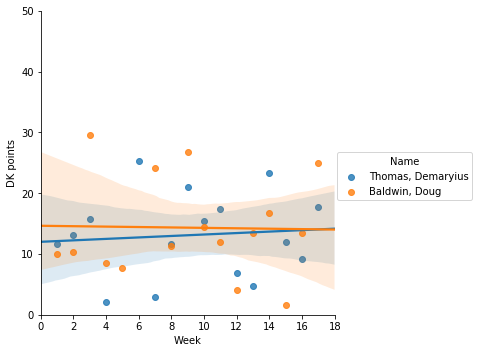

In [145]:
ps.reset_index(inplace=True)
sns.lmplot(x="Week", y="DK points", data=ps, hue="Name")
plt.ylim(0, 50)
plt.show()